In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# for content cost 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H, n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [3]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [4]:
# for layer style cost
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))

    return J_style_layer

In [5]:
# weights for different layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
# for style cost
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [7]:
# total cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

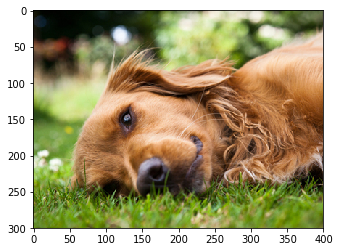

In [41]:
# loading the content image and normalizing it
content_image = imageio.imread("images/dog1.jpg")
plt.imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

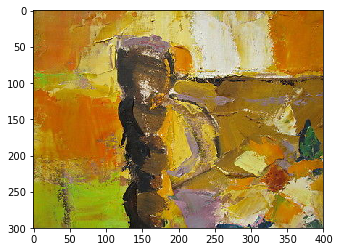

In [42]:
# loading the style image and normalizing it
style_image = imageio.imread("images/style4.jpg")
plt.imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


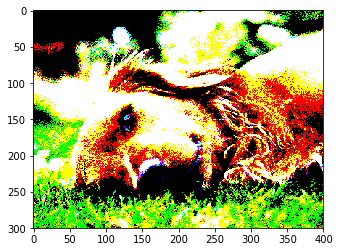

In [43]:
# generating a noise image from the content image
generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0])

In [12]:
# load the model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
#print(model)

In [44]:
# assign the content image to be the input of the model.  
sess.run(model['input'].assign(content_image))

# the output tensor of layer conv4_2
out = model['conv4_2']

# hidden layer activation
a_C = sess.run(out)
a_G = out

# the content cost
J_content = compute_content_cost(a_C, a_G)

In [45]:
# assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [46]:
# compute the total cost
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [47]:
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [48]:
def model_nn(sess, input_image, num_iterations = 800):
    
    # initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # displaying the total cost, content cost and style cost after every 20 iterations
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            # save_image("f4/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image663.jpg', generated_image)
    
    return generated_image

In [50]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 9459524000.0
content cost = 12152.397
style cost = 236485040.0
Iteration 20 :
total cost = 1077250700.0
content cost = 22217.19
style cost = 26925712.0
Iteration 40 :
total cost = 333392320.0
content cost = 22388.482
style cost = 8329211.0
Iteration 60 :
total cost = 193116130.0
content cost = 22722.553
style cost = 4822222.5
Iteration 80 :
total cost = 142438880.0
content cost = 23155.633
style cost = 3555183.2
Iteration 100 :
total cost = 114007640.0
content cost = 23507.457
style cost = 2844314.2
Iteration 120 :
total cost = 94493260.0
content cost = 23792.195
style cost = 2356383.5
Iteration 140 :
total cost = 80149690.0
content cost = 24031.84
style cost = 1997734.1
Iteration 160 :
total cost = 69227420.0
content cost = 24245.344
style cost = 1724624.1
Iteration 180 :
total cost = 60646984.0
content cost = 24429.451
style cost = 1510067.2
Iteration 200 :
total cost = 53725096.0
content cost = 24585.205
style cost = 1336981.1
Iteration 220 :
total cost = 

array([[[[  -3.9414988 ,  -11.892916  ,  -30.249037  ],
         [  -1.7024642 ,  -34.473488  ,  -67.15438   ],
         [  12.368058  ,  -61.741924  ,  -70.87864   ],
         ...,
         [ -44.568386  ,  -45.37228   ,  -11.391809  ],
         [ -80.2646    ,  -60.236137  ,  -18.087332  ],
         [ -86.30941   ,  -75.77067   ,  -39.530266  ]],

        [[  -1.8612632 ,  -34.764652  ,  -69.901665  ],
         [  -5.2732453 ,  -41.948338  ,  -68.4042    ],
         [  23.362362  ,  -56.048     ,  -75.63466   ],
         ...,
         [ -23.697023  ,  -21.638186  ,  -34.913815  ],
         [ -55.460728  ,  -34.68252   ,  -27.600327  ],
         [ -53.76223   ,  -38.890003  ,  -88.59848   ]],

        [[ -14.728256  ,  -27.84288   ,  -78.490974  ],
         [  25.173395  ,  -61.945965  ,  -74.34585   ],
         [   1.60777   ,  -44.145866  ,  -80.14251   ],
         ...,
         [  -8.403049  ,  -44.716324  ,  -75.87304   ],
         [ -41.814026  ,  -40.662567  ,  -62.002937  ],
  

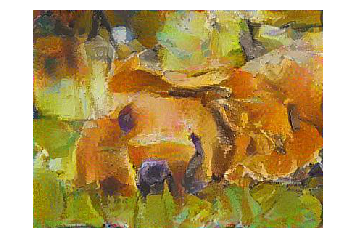

In [51]:
i = imageio.imread('output/generated_image663.jpg')
plt.axis('off')
plt.imshow(i)